# PXD009019 Spectral Counting (SpC) Quality Control

## Phil Wilmarth, OHSU

### July 2019

Some samples had low protein ID numbers and smaller numbers of PSMs. They might need to be excluded. We can look at boxplots to see how data distributions look, at MDS clustering plots to see if samples group by condition, and coefficient of variation distributions to assess sample quality. 

---

## Load R libraries

In [1]:
library("tidyverse")
library("edgeR")
library("limma")
library("psych")
library("gridExtra")
library("scales")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: limma

Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following objects are masked from ‘package:psych’:

    alpha, rescale

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



## Data was prepped in Excel and exported to text file

The PAW pipeline, like most proteomics summary tables, has a lot more information that we need for the statistical analysis. Selecting the relevant columns from a large table is not too hard to do in R. Row filtering can be trickier. Decoy protein sequences and common contaminants are easy to drop. Missing data and filtering out low abundance data can be trickier.

The situation here needs to also allow for proteins that are in only one condition. One way to handle that is to require a minimum average spectral count across the 10 samples of 2.5. If we have expression in one condition of 5 (a level that is well above the minimum detection of 1 or 2) and nothing in the other condition, we will hit the average of 2.5. We did that in Excel and also tested for zero values and replaced them with a count of 0.25. This gives us 669 proteins that we can test.

### Read in the data

The data exported in the `QC_check_669x19.txt` file excluded contaminants, decoys, and any proteins with an average SpC of less than 2.5. We will read that data in and separate the accessions from the count data.

In [2]:
# read in the prepped data
paw_spc <- read_tsv("QC_check_669x19.txt")

# save accessions in vector and remove from data table
accession <- paw_spc$Accession
paw_spc <- select(paw_spc, -Accession)

# replace zeros with 0.25
paw_spc[paw_spc == 0] <- 0.25
head(paw_spc)
nrow(paw_spc)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character()
)
See spec(...) for full column specifications.


Control-08,Control-09,Control-10,Control-11,Control-12,Control-18,Control-19,Control-20,Lepto-01,Lepto-02,Lepto-03,Lepto-04,Lepto-05,Lepto-06,Lepto-13,Lepto-14,Lepto-15,Lepto-16,Lepto-17
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1083.5,652.0,545.3,524.3,465.4,434.5,1142.5,877.1,625.4,1412.6,498.5,625.3,1311.6,1665.3,1201.8,946.1,1002.8,780.5,1206.6
354.0,183.0,130.0,73.0,64.0,84.0,355.0,20.0,239.0,663.0,130.0,191.0,414.0,440.0,337.0,244.0,360.0,335.0,440.0
192.0,109.0,206.0,88.0,154.0,173.0,314.0,455.0,166.0,39.0,251.0,354.0,160.0,62.0,186.0,280.0,154.0,117.0,197.0
282.0,150.9,146.9,89.0,75.0,75.0,150.0,203.0,168.0,349.0,90.0,112.0,271.0,355.0,231.8,201.0,169.0,223.0,217.0
131.0,102.0,17.0,25.0,21.0,40.0,49.0,112.0,127.0,541.0,105.0,151.0,336.0,433.0,169.0,126.0,291.0,215.0,366.0
114.0,104.0,84.0,24.0,24.0,70.0,56.0,151.0,214.0,67.0,395.0,545.0,307.0,71.0,82.0,430.0,297.0,83.0,236.0


[1] 669

### Normalize data by total counts

We will do a basic total count normalization by scaling each run to the average total SpC. We will look at the normalized count distributions with boxplots.

SL Factors:
 Control-08 -> 1.047887
 Control-09 -> 1.058103
 Control-10 -> 1.409200
 Control-11 -> 1.372545
 Control-12 -> 1.056654
 Control-18 -> 1.113593
 Control-19 -> 1.031992
 Control-20 -> 0.968974
 Lepto-01 -> 0.826236
 Lepto-02 -> 1.079813
 Lepto-03 -> 0.729820
 Lepto-04 -> 0.872277
 Lepto-05 -> 0.788919
 Lepto-06 -> 1.155092
 Lepto-13 -> 0.798372
 Lepto-14 -> 0.792294
 Lepto-15 -> 1.054273
 Lepto-16 -> 1.706634
 Lepto-17 -> 1.018814


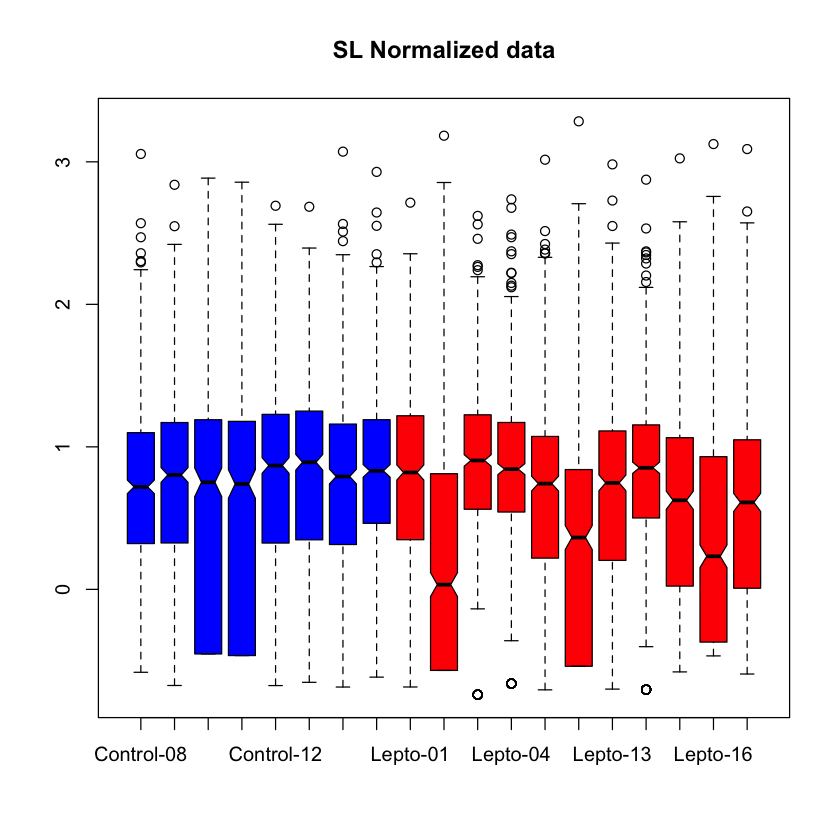

In [3]:
# function for simple normalization
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# normalize the data before plotting
color <- c(rep('blue', 8), rep('red', 11))
paw_sl <- SL_Norm(paw_spc, color)

## Some distributions look quite different

## See how the samples cluster

We can use the TMM normalization in edgeR and see how samples cluster in an MDS plot.

In [4]:
# load the data into edgeR data structures
# group labels need to be factors
group <- c(rep("Control", 8), rep("lepto", 11))
y <- DGEList(counts = paw_spc, group = group, genes = accession)

# run the TMM normalization (and library size corrections)
y <- calcNormFactors(y)

# check normalizations
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Control-08,Control,10491.80,1.1413804
Control-09,Control,10390.50,1.1066609
Control-10,Control,7801.75,0.9629364
Control-11,Control,8010.10,0.9524250
Control-12,Control,10404.75,1.1585797
Control-18,Control,9872.75,1.2964840
Control-19,Control,10653.40,1.1002452
Control-20,Control,11346.25,1.2620264
Lepto-01,lepto,13306.40,1.0872991


## Get the TMM normalized data out of edgeR

EdgeR uses the normalization factors as offsets in its modeling. The normalized data values have to be computed.

Overall Factors (lib.size+TMM):
 Control-08 -> 0.918088
 Control-09 -> 0.956123
 Control-10 -> 1.463440
 Control-11 -> 1.441106
 Control-12 -> 0.912026
 Control-18 -> 0.858933
 Control-19 -> 0.937966
 Control-20 -> 0.767792
 Lepto-01 -> 0.759897
 Lepto-02 -> 2.245925
 Lepto-03 -> 0.545577
 Lepto-04 -> 0.656759
 Lepto-05 -> 0.776799
 Lepto-06 -> 1.907580
 Lepto-13 -> 0.817595
 Lepto-14 -> 0.664092
 Lepto-15 -> 1.200868
 Lepto-16 -> 2.151043
 Lepto-17 -> 1.140937


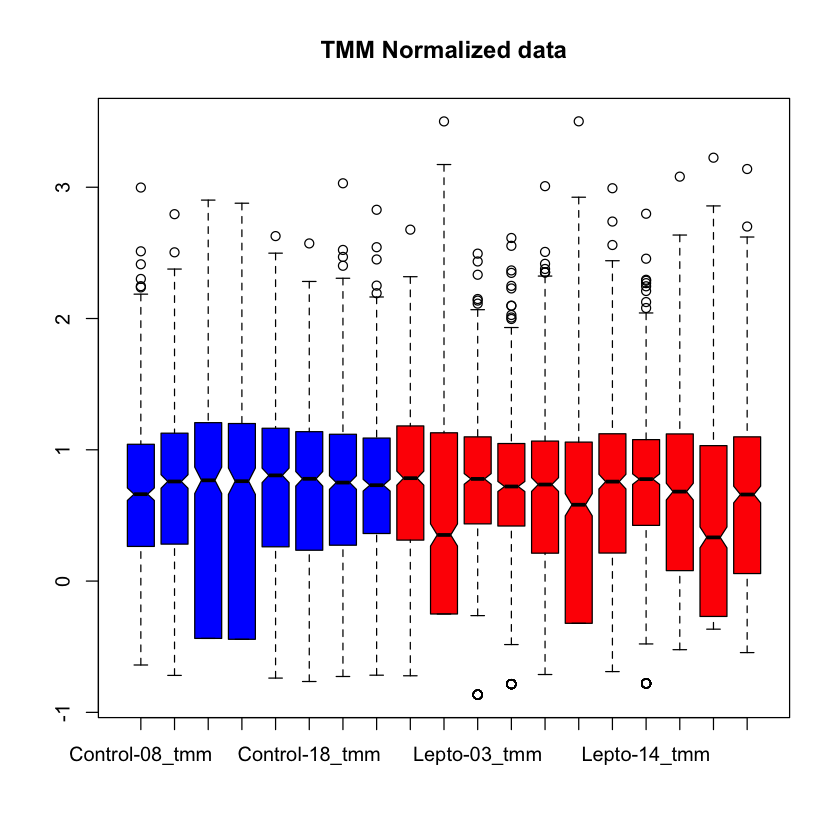

In [5]:
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    df_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(df_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    df_tmm
}

# get normalized data and check boxplots
paw_spc_tmm <- apply_tmm_factors(y, color)

## Still have distribution tails after TMM

The two control samples with low tails do have the medians in line with the other control samples. The three odd-looking lepto samples have both low tails and medians after TMM normalization that are too low (not in line with the other lepto samples).

## Check how samples cluster by condition

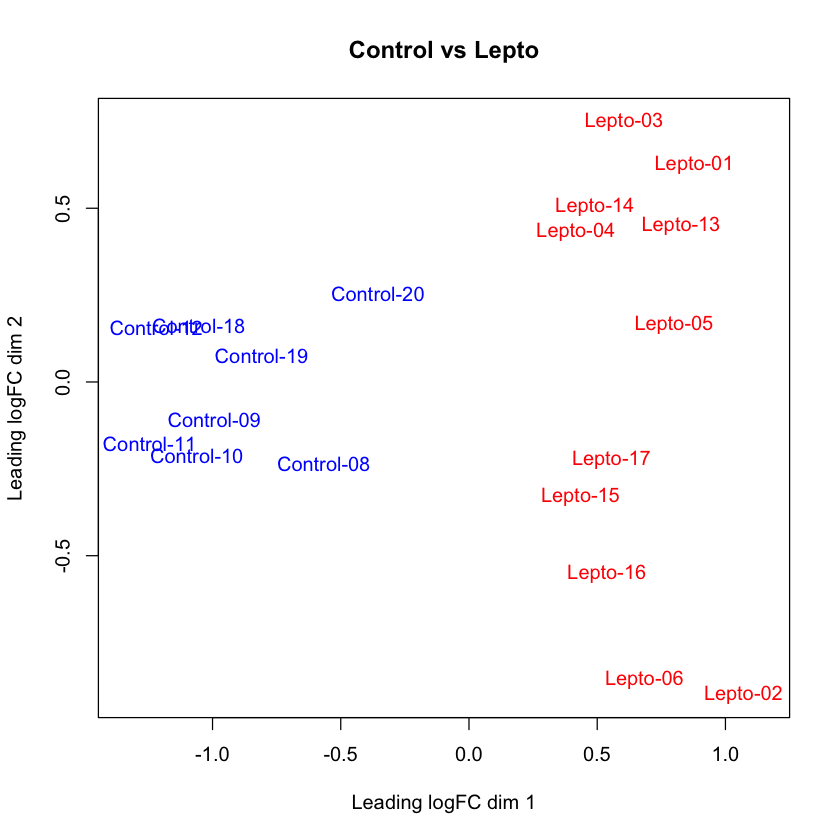

In [6]:
# check clustering
plotMDS(y, col = color, main = "Control vs Lepto")

## Clustering separates by condition

The odd distribution effects seem to be smaller than the differences between conditions, at least according to the MDS clustering.

## CV distributions are also very useful

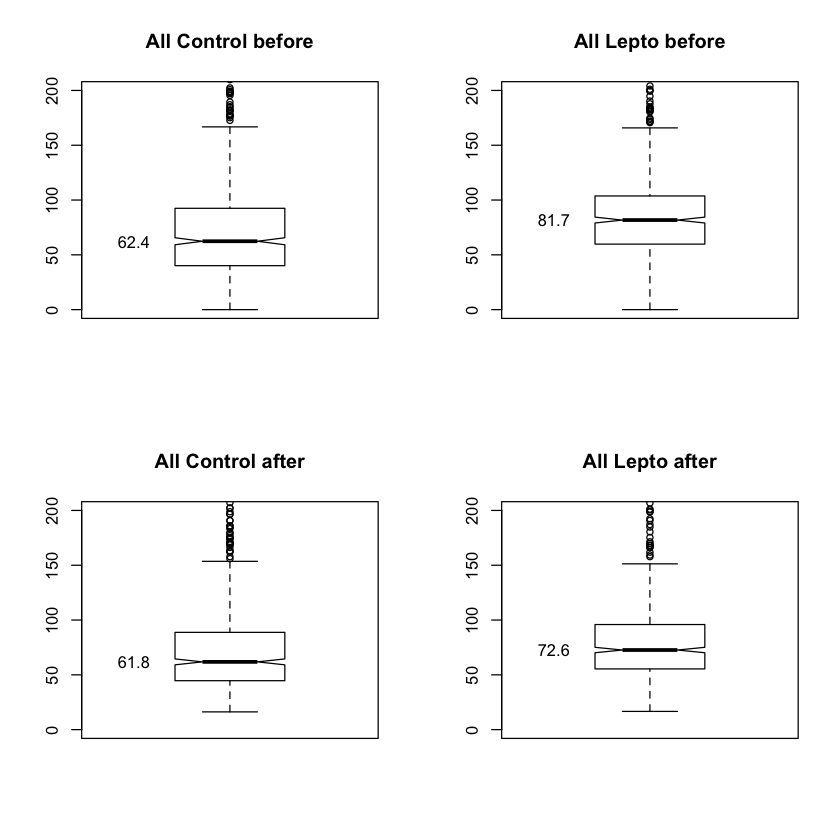

In [7]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# define the columns for each condition
C <- 1:8
L <- 9:19
CD <- c(1, 2, 5, 6, 7, 8)
LD <- c(9, 11, 12, 13, 15, 16, 17, 19)


# see what effect TMM had on CV distributions
par(mfrow = c(2, 2))
labeled_boxplot(paw_spc[C], 200, "All Control before")
labeled_boxplot(paw_spc[L], 200, "All Lepto before")
labeled_boxplot(paw_spc_tmm[C], 200, "All Control after")
labeled_boxplot(paw_spc_tmm[L], 200, "All Lepto after")

## Some samples could be excluded

Lepto samples 2, 6, and 16 have odd data distributions (box plots) and are kind of on the bottom of the cluster plot. The medians for those distributions are not too well in line with the other lepto samples (they are all low). Controls 10 and 11 have more small counts - the boxes in the distributions are very tailed on the low side compared to the other controls. Interestingly, they seem to cluster with the other controls.

The three lepto samples has atypically low total protein ID numbers (and smaller total PSM numbers) and seem not so similar to the other lepto samples. The two controls were low on the protein ID numbers but not as dramatically as the lepto samples. 

## Drop some samples and see how CVs, etc. change

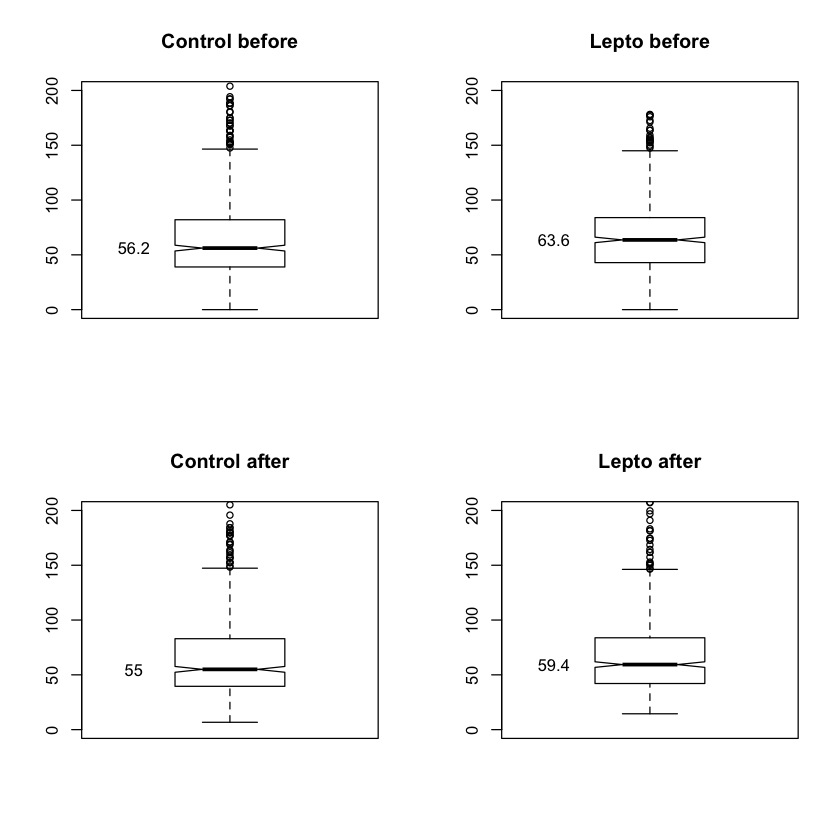

In [8]:
# dropping 2 controls and 3 lepto samples
par(mfrow = c(2, 2))
labeled_boxplot(paw_spc[CD], 200, "Control before")
labeled_boxplot(paw_spc[LD], 200, "Lepto before")
labeled_boxplot(paw_spc_tmm[CD], 200, "Control after")
labeled_boxplot(paw_spc_tmm[LD], 200, "Lepto after")
par(mfrow = c(1, 1))

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Control-08,Control,10491.80,0.8984815
Control-09,Control,10390.50,1.1414117
Control-10,Control,7801.75,0.9145459
Control-11,Control,8010.10,0.9431195
Control-12,Control,10404.75,1.2761884
Control-18,Control,9872.75,1.2443434
Control-19,Control,10653.40,1.0171370
Control-20,Control,11346.25,1.0343960
Lepto-01,lepto,13306.40,1.0800362


Overall Factors (lib.size+TMM):
 Control-08 -> 1.211643
 Control-09 -> 0.963064
 Control-10 -> 1.600798
 Control-11 -> 1.511922
 Control-12 -> 0.860176
 Control-18 -> 0.929727
 Control-19 -> 1.054062
 Control-20 -> 0.973184
 Lepto-01 -> 0.794758
 Lepto-03 -> 0.630650
 Lepto-04 -> 0.800054
 Lepto-05 -> 0.846547
 Lepto-13 -> 0.918793
 Lepto-14 -> 0.789191
 Lepto-15 -> 1.508540
 Lepto-17 -> 1.522637


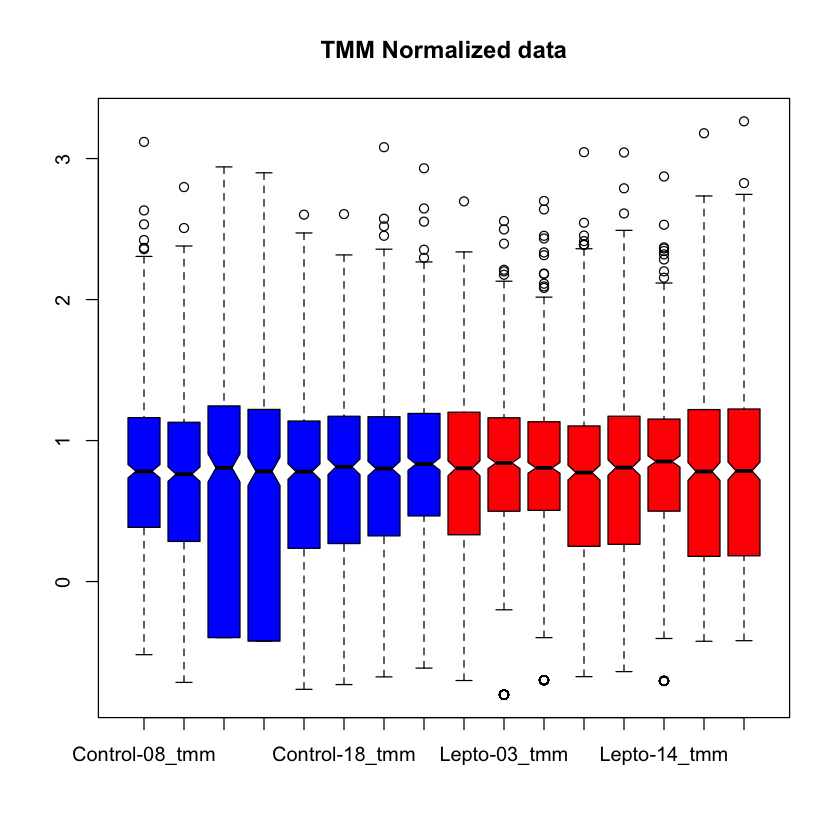

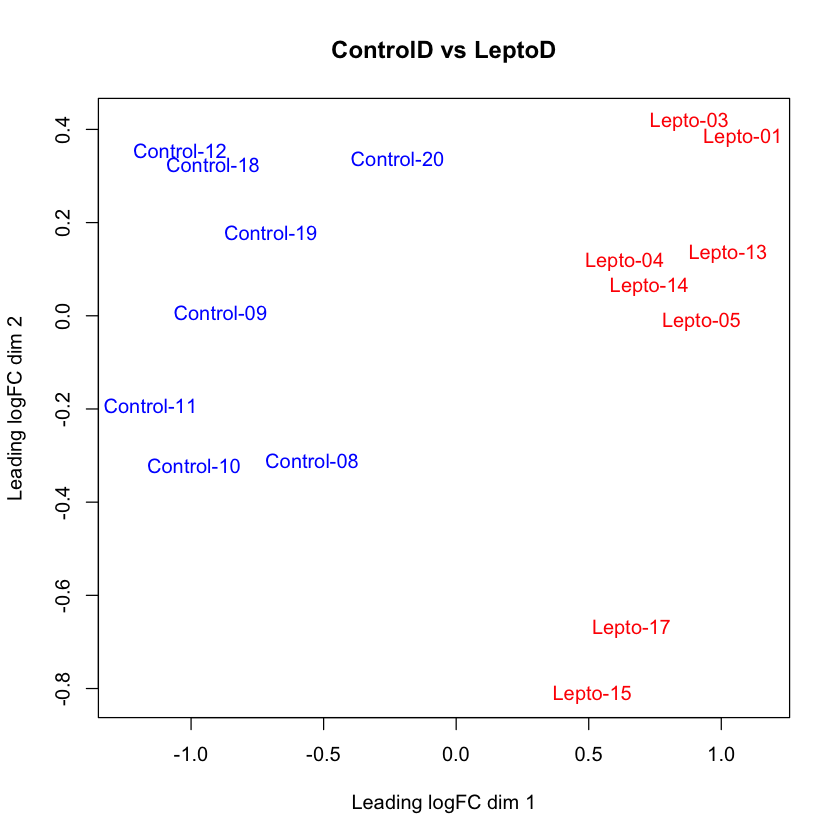

In [9]:
# load the data into edgeR data structures
# group labels need to be factors
countsd <- paw_spc[c(C, LD)]
colord <- c(rep('blue', 8), rep('red', 8))
groupd <- c(rep("Control", 8), rep("lepto", 8))
yd <- DGEList(counts = countsd, group = groupd, genes = accession)

# run the TMM normalization (and library size corrections)
yd <- calcNormFactors(yd)

# check normalizations
yd$samples

# get normalized data and make boxplots
paw_spc_tmm <- apply_tmm_factors(yd, colord)

# check clustering
plotMDS(yd, col = colord, main = "ControlD vs LeptoD")

## Data after excluding some sample looks reasonable

The long, bottom tails on the box plots for two controls and 3 lepto samples were pretty different from the other samples. Excluding those samples had some pretty reasonable improvements in CVs also.

The clustering did not really indicate that the two control samples with low tails were that atypical. Dropping those only reduced the median CVs by about 5% for the controls. Those samples do not have large TMM adjustment factors. It might be safer to keep all 8 controls. The three lepto samples are pretty clear outliers. Removing them changes the median CVs by 20% before TMM and still 14% after TMM. We will do the statistical analysis on 8 controls and 8 lepto samples in a separate notebook.

## Log the session

In [10]:
# log the session
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.0.0    gridExtra_2.3   psych_1.8.12    edgeR_3.24.3   
 [5] limma_3.38.3    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.1    
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_1.0.1      
 [5] haven_2.1.0      lattice_0.20-38  vctrs_0.1.0      colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.